<a href="https://colab.research.google.com/github/tomerz89/tomerz89/blob/main/Copy_of_RMA_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RMA (Return Merchandise Authorization) Prediction assignment

**Welcome to 'RMA Prediction' assignment, Below is a brief background:**

Return merchandise authorization (RMA) is the process of returning a product to receive a refund, replacement, or repair during the product's warranty period. 

In the chip manufacturing industry, in particular, the manufacturers have an interest in detect these units before it being shipped and reach the market for a few reasons:

- The cost of a single unit during production is nil, compared to replacing an entire end device that causes several times more damage

- The damage done to a company's reputation when a new device is returned as bad one can be very significant

- A malfunctioning unit can cause significant damage (you don't want such bad unit placed in ABS system of your car :) )

There are detailed test programs in which thousands of tests are performed on chips during production to ensure quality and prevent such cases.

RMA units along with non-RMA units have passed all test cycles properly, and yet have been found to be defective in the field.

The manufacturers are aware that there are such units and their goal is to predict which units will be malfunctioning soon even though they now appear to be working properly. Once predicting such units, they will mark them as bad and not ship them to customers.
Secondary goal is to avoid excessive scrap of good units by marking good units as bad to avoid significant financial loss.


This use case is called "RMA Prediction" and this is the challenge you are required to deal with in this assignment!

**Technical notes:**

- Please follow the steps in this notebook

- Please write all your code inside this notebook only

- Please feel free to add more cells as you need

- The goal of this assigment is not only the best model:
    - There is also value in clean code, and in orderly and clear work
    - Use visualizations and comments on the reasons for the actions you take
    - It is recommended to show in the notebook also experiments you tried along the way


- Avoid over-fitting

    - Your prediction results will be tested on a test set that its lables are not available to you


Good Luck!

# Packages

First, import all the packages you'll need during this assignment. You can finish successfully this assigment with these packages only but feel free to use more libraries if you find it helpful

- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [sklearn](https://scikit-learn.org/stable/) is the most useful and robust library for machine learning in Python.
- [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) Is the metric you should use to evaluate the performance of your model.
- [pickle](https://docs.python.org/3/library/pickle.html) is a library for serializing and de-serializing Python object structures, also called marshalling or flattening
- np.random.seed(1) is used to keep all the random function calls consistent. It helps grade your work. Please don't change the seed! 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import f1_score
import pickle
import seaborn as sns
np.random.seed(seed=1)
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import plot_importance


# Load The Data

First, let's load the data:

In [ ]:
url_data_train = (r'https://raw.githubusercontent.com/NI-DS/rma_assignment/main/Input/rma_train_data.csv')
url_data_test = (r'https://raw.githubusercontent.com/NI-DS/rma_assignment/main/Input/rma_test_data.csv')
df_rma_train, df_rma_test = pd.read_csv(url_data_train), pd.read_csv(url_data_test)

We will now examine the dimensions of the data:

In [ ]:
df_rma_train.shape, df_rma_test.shape

((3616, 17), (905, 16))

It can be seen that in the train set there is one column more than the test set.

We will now print the first five rows of the DataFrame to see the values of the data.

In [ ]:
df_rma_train.head()

,Test_0,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9,Test_10,Test_11,Test_12,Test_13,Test_14,Test_15,RMA
0,261.36,E,Low,OP-1,True,102.14,False,True,2018.0,58.9,nov,136,1,120,1,TP-1549,False
1,268.62,H,Mid,OP-17,True,655.42,False,True,2018.0,62.0,apr,114,1,152,2,TP-1549,False
2,297.66,F,Low,OP-1,True,605.50,False,False,2018.0,65.1,nov,285,3,116,4,TP-1549,False
3,515.46,NaN,Low,OP-17,True,144.78,True,True,2018.0,83.7,jan,208,1,93,2,TP-1549,False
4,290.40,D,Low,OP-4,True,416.22,False,True,2019.0,37.2,may,58,2,334,1,TP-1549,False


In [ ]:
df_rma_test.head()

,Test_0,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9,Test_10,Test_11,Test_12,Test_13,Test_14,Test_15
0,268.62,C,Low,OP-17,True,1116.14,False,True,2018.0,6.2,feb,289,2,174,4,TP-9941
1,268.62,D,Low,OP-4,True,53.00,False,True,2018.0,18.6,may,226,1,363,3,TP-9941
2,246.84,D,Low,OP-1,True,275.56,False,True,2018.0,62.0,apr,470,1,150,5,TP-9941
3,333.96,B,Low,OP-1,True,53.00,False,True,2018.0,68.2,jun,154,1,124,1,TP-9941
4,261.36,B,Mid,OP-1,True,438.32,False,True,2018.0,55.8,nov,177,2,174,1,TP-9941


As you can see there are 16 independent variables all 'Test_i' (i: 0-15) columns, and one variable is dependent, 'RMA' column.

The purpose of the assignment is to predict the value of the 'RMA' variable according to the value of the other variables in the data. Please remember to use visualizations, explain the actions you perform by comments, and show your workflow clearly.

Note that the test set has no labels. Your assignment goal is to build a machine learning model that will predict the labels for it.

# Exploratory Data Analysis (EDA)

## What is EDA? 

Exploratory Data Analysis: this is unavoidable and one of the major step to fine-tune the given data set(s) in a different form of analysis to understand the insights of the key characteristics of various entities of the data set like column(s), row(s) by applying Pandas, NumPy, Statistical Methods, and Data visualization packages. EDA process should make you familiar with your data set.

- Outcome of this phase can be but not limited to:

    - Dataset charechtaristics.
    - Features relationship.
    - Target ('RMA' column) insights. 
    - Any interesting thing you can learn about the dataset.
    
**Goal of this phase is to implement EDA process for RMA data set**

In [ ]:
df_rma_train.dtypes

Test_0     float64
Test_1      object
Test_2      object
Test_3      object
Test_4        bool
Test_5     float64
Test_6        bool
Test_7        bool
Test_8     float64
Test_9     float64
Test_10     object
Test_11      int64
Test_12      int64
Test_13      int64
Test_14      int64
Test_15     object
RMA           bool
dtype: object

In [ ]:
df_rma_train.describe()

,Test_0,Test_5,Test_8,Test_9,Test_11,Test_12,Test_13,Test_14
count,3616.000000,3616.000000,2571.000000,3616.000000,3616.000000,3616.000000,3616.000000,3616.000000
mean,299.029281,424.817760,2018.094127,49.314519,268.305310,2.797566,39.754701,0.529591
std,77.186039,803.049832,0.292062,25.587803,269.794165,3.009244,101.007732,1.630012
min,137.940000,-488.320000,2018.000000,3.100000,4.000000,1.000000,-1.000000,0.000000
25%,239.580000,70.940000,2018.000000,24.800000,104.000000,1.000000,-1.000000,0.000000
50%,283.140000,167.140000,2018.000000,49.600000,188.000000,2.000000,-1.000000,0.000000
75%,355.740000,435.070000,2018.000000,65.100000,328.000000,3.000000,-1.000000,0.000000
max,631.620000,18561.880000,2019.000000,96.100000,3025.000000,44.000000,871.000000,25.000000


In [ ]:
# The target RMA is boolean, will be easier to work with as binary to examine the rlations, when predictions are eventually made its possible to transform RMA back to boolean 
df_rma_train['RMA'] =df_rma_train['RMA'].replace('False', 0.0)
df_rma_train['RMA'] =df_rma_train['RMA'].replace('True', 1.0)
df_rma_train['RMA']=df_rma_train['RMA'].astype('float64')

In [ ]:
corr_matrix=df_rma_train.corr()
corr_matrix

,Test_0,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9,Test_11,Test_12,Test_13,Test_14,RMA
Test_0,1.000000,0.014811,0.081823,0.189637,0.005672,0.207209,-0.013287,-0.004954,-0.003104,0.000168,0.004483,0.054644
Test_4,0.014811,1.000000,0.068241,0.008545,0.053202,0.018210,0.007820,0.011968,0.006570,0.032281,0.027117,0.006852
Test_5,0.081823,0.068241,1.000000,0.045043,0.070272,0.034207,-0.004385,-0.012944,0.002858,0.007048,0.021224,0.008348
Test_6,0.189637,0.008545,0.045043,1.000000,0.030939,0.045482,0.020687,-0.015333,-0.008357,-0.116531,-0.032836,0.096261
Test_7,0.005672,0.053202,0.070272,0.030939,1.000000,-0.001141,0.017318,0.011232,-0.004507,0.022184,0.006852,0.067987
Test_8,0.207209,0.018210,0.034207,0.045482,-0.001141,1.000000,0.048861,-0.031971,0.038388,-0.022520,0.008127,-0.003233
Test_9,-0.013287,0.007820,-0.004385,0.020687,0.017318,0.048861,1.000000,-0.018218,0.165634,-0.096509,-0.061036,-0.006770
Test_11,-0.004954,0.011968,-0.012944,-0.015333,0.011232,-0.031971,-0.018218,1.000000,-0.070853,0.007608,0.021025,0.411011
Test_12,-0.003104,0.006570,0.002858,-0.008357,-0.004507,0.038388,0.165634,-0.070853,1.000000,-0.100323,-0.072938,-0.059333
Test_13,0.000168,0.032281,0.007048,-0.116531,0.022184,-0.022520,-0.096509,0.007608,-0.100323,1.000000,0.589558,0.103067


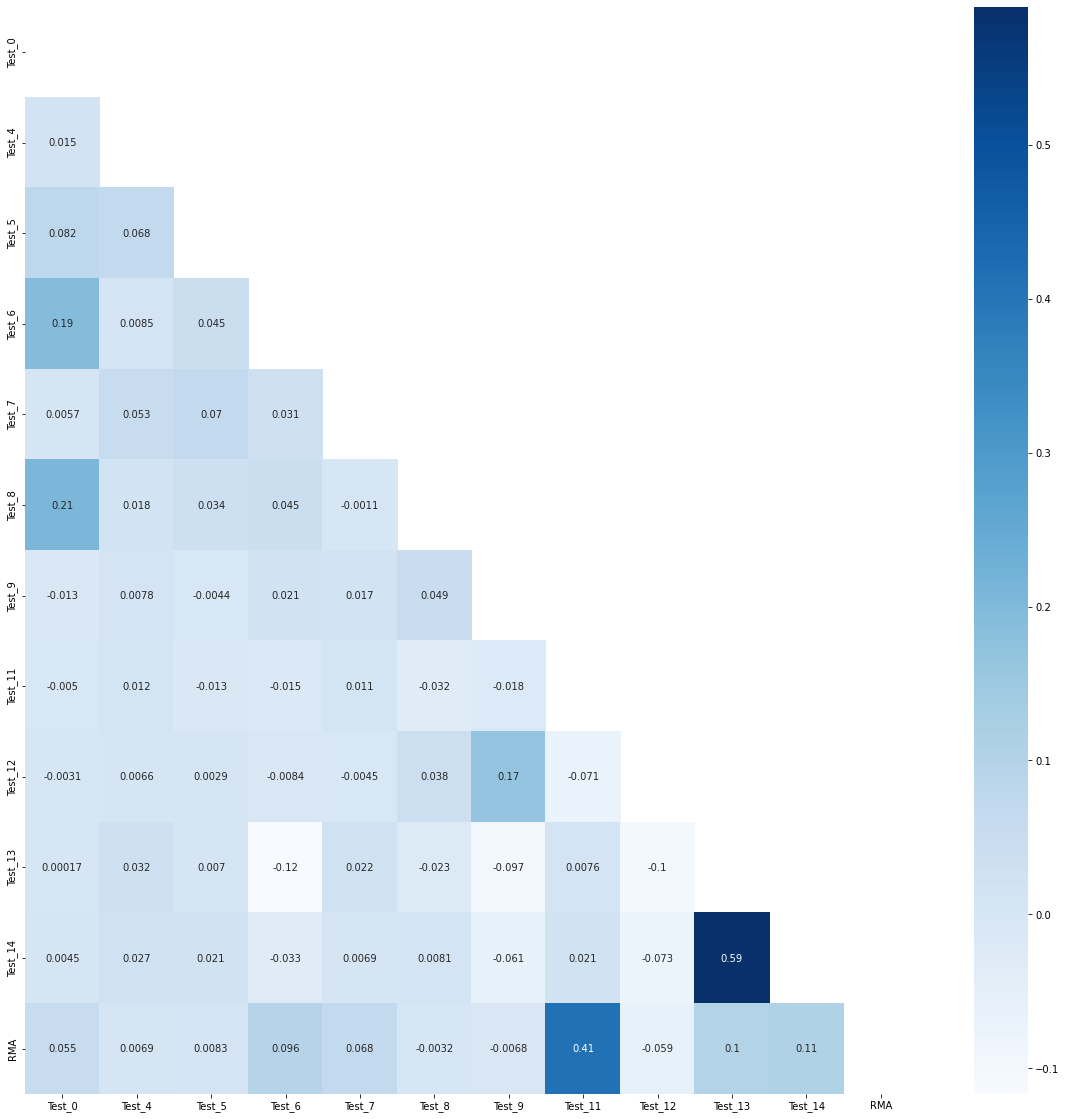

In [ ]:
plt.figure(figsize=(20, 20))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
corr_heatmap=sns.heatmap(df_rma_train.corr(), cmap="Blues", annot=True, mask=mask)

In [ ]:
num_cols = [col for col in df_rma_train.columns if df_rma_train[col].dtype == "float64"]
for col in num_cols:
    print('Pearson correlation for feature', col)
    print(abs(df_rma_train.corr(method='pearson').loc[:,col]).sort_values(ascending=False))


Pearson correlation for feature Test_0
Test_0     1.000000
Test_8     0.207209
Test_6     0.189637
Test_5     0.081823
RMA        0.054644
Test_4     0.014811
Test_9     0.013287
Test_7     0.005672
Test_11    0.004954
Test_14    0.004483
Test_12    0.003104
Test_13    0.000168
Name: Test_0, dtype: float64
Pearson correlation for feature Test_5
Test_5     1.000000
Test_0     0.081823
Test_7     0.070272
Test_4     0.068241
Test_6     0.045043
Test_8     0.034207
Test_14    0.021224
Test_11    0.012944
RMA        0.008348
Test_13    0.007048
Test_9     0.004385
Test_12    0.002858
Name: Test_5, dtype: float64
Pearson correlation for feature Test_8
Test_8     1.000000
Test_0     0.207209
Test_9     0.048861
Test_6     0.045482
Test_12    0.038388
Test_5     0.034207
Test_11    0.031971
Test_13    0.022520
Test_4     0.018210
Test_14    0.008127
RMA        0.003233
Test_7     0.001141
Name: Test_8, dtype: float64
Pearson correlation for feature Test_9
Test_9     1.000000
Test_12    0.1656

 Test_11 is significant in order to predict RMA compared to all other features, it should be given extra attention

In [ ]:
for col in df_rma_train.columns:
  print(df_rma_train[col].value_counts())

246.84    175
232.32    170
225.06    157
261.36    155
239.58    153
         ... 
624.36      1
609.84      1
493.68      1
588.06      1
631.62      1
Name: Test_0, Length: 67, dtype: int64
C    783
D    747
F    614
H    392
B    323
L    184
E    153
G    134
A    102
K     87
J     66
Name: Test_1, dtype: int64
Low     2232
Mid      969
High     415
Name: Test_2, dtype: int64
OP-1     1860
OP-17    1090
OP-4      525
Name: Test_3, dtype: int64
True     3557
False      59
Name: Test_4, dtype: int64
 53.00     289
 53.52      17
 53.26      11
 54.04      11
 62.10      10
          ... 
 130.48      1
 469.26      1
 392.04      1
-383.80      1
 268.02      1
Name: Test_5, Length: 2036, dtype: int64
False    2026
True     1590
Name: Test_6, dtype: int64
True     3054
False     562
Name: Test_7, dtype: int64
2018.0    2329
2019.0     242
Name: Test_8, dtype: int64
62.0    209
55.8    172
58.9    159
43.4    159
21.7    157
65.1    151
24.8    151
52.7    145
18.6    145
49.6    14

In [ ]:
df_rma_train.isna().sum()
# Most nan's will be handled when categorial features are turned into indicators (they will simply have no indicator turned on)

Test_0        0
Test_1       31
Test_2        0
Test_3      141
Test_4        0
Test_5        0
Test_6        0
Test_7        0
Test_8     1045
Test_9        0
Test_10       0
Test_11       0
Test_12       0
Test_13       0
Test_14       0
Test_15    2967
RMA           0
dtype: int64

In [ ]:
for col in df_rma_test.columns:
  print(df_rma_test[col].value_counts())

246.84    56
232.32    54
268.62    45
225.06    42
297.66    34
239.58    33
261.36    33
254.10    30
290.40    28
275.88    27
355.74    27
348.48    26
312.18    26
283.14    25
304.92    23
217.80    22
326.70    21
333.96    21
399.30    20
377.52    20
384.78    20
203.28    19
406.56    19
428.34    18
370.26    18
210.54    18
196.02    18
341.22    18
319.44    17
363.00    16
413.82    15
392.04    15
181.50    13
188.76    11
421.08    11
435.60     9
174.24     6
442.86     3
166.98     3
522.72     2
471.90     2
457.38     2
515.46     2
464.64     2
508.20     2
159.72     2
152.46     2
559.02     2
573.54     1
486.42     1
479.16     1
544.50     1
493.68     1
137.94     1
529.98     1
Name: Test_0, dtype: int64
D    199
C    186
F    154
B     94
H     86
L     46
G     34
E     30
A     26
K     25
J     18
Name: Test_1, dtype: int64
Low     565
Mid     227
High    113
Name: Test_2, dtype: int64
OP-1     446
OP-17    260
OP-4     153
Name: Test_3, dtype: int64
Tru

In [ ]:
df_rma_test.isna().sum()

Test_0       0
Test_1       7
Test_2       0
Test_3      46
Test_4       0
Test_5       0
Test_6       0
Test_7       0
Test_8     279
Test_9       0
Test_10      0
Test_11      0
Test_12      0
Test_13      0
Test_14      0
Test_15    738
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc639d76a10>]],
      dtype=object)

<Figure size 6000x6000 with 0 Axes>

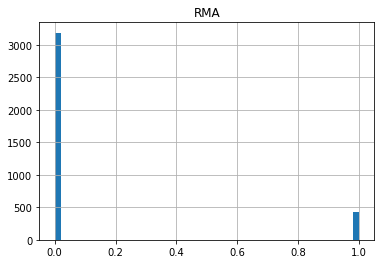

In [ ]:
plt.figure(figsize=(40, 40), dpi=150)
df_rma_train.hist(column='RMA', bins=50)
# RMA=1 is a rare event, must be taken into consideration when splitting training and validation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc639da00d0>]],
      dtype=object)

<Figure size 6000x6000 with 0 Axes>

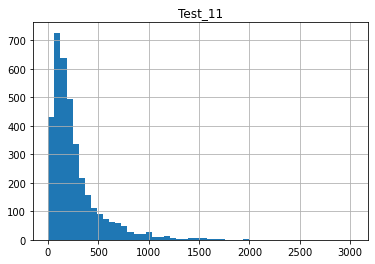

In [ ]:
plt.figure(figsize=(40, 40), dpi=150)
df_rma_train.hist(column='Test_11', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc638308690>]],
      dtype=object)

<Figure size 6000x6000 with 0 Axes>

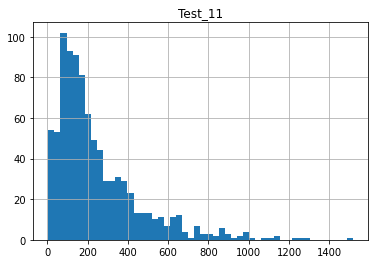

In [ ]:
plt.figure(figsize=(40, 40), dpi=150)
df_rma_test.hist(column='Test_11', bins=50)

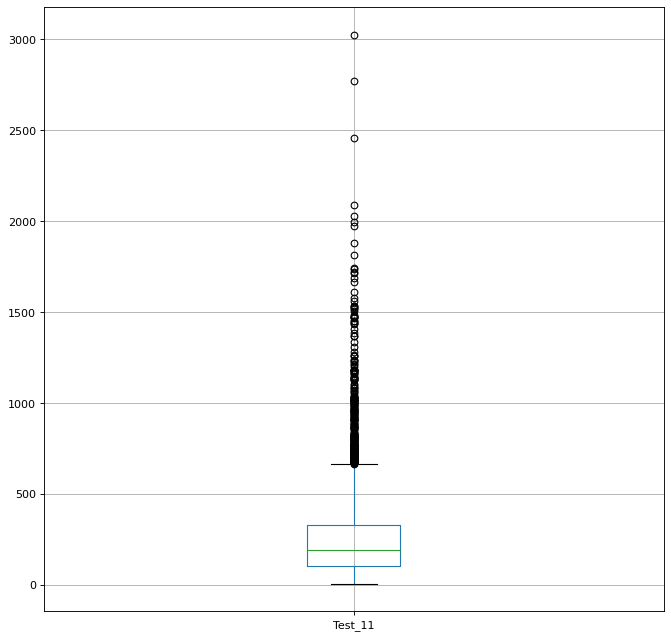

In [ ]:
plt.figure(figsize=(10, 10), dpi=80)
df_rma_train.boxplot(column='Test_11')

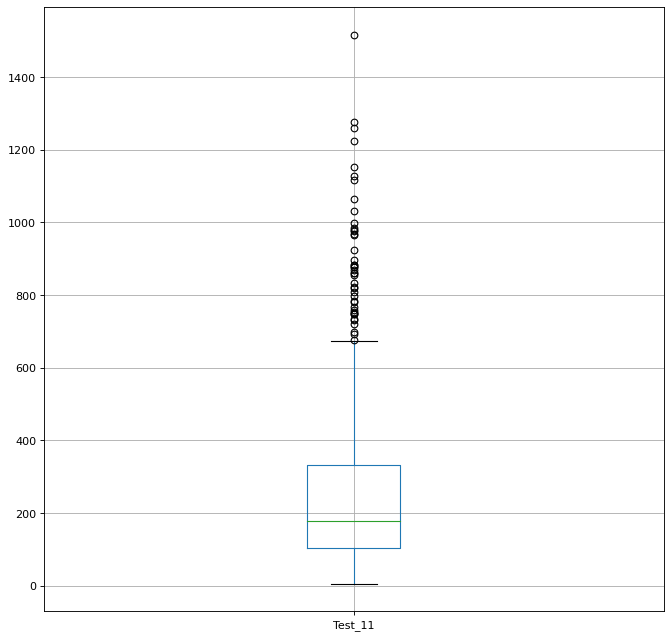

In [ ]:
plt.figure(figsize=(10, 10), dpi=80)
df_rma_test.boxplot(column='Test_11')

# Data pre-processing

## Data preprocessing is a key step in Machine Learning Pipeline.

Quality of data directly affects the ability of a model to learn useful information out of it.

Therefore, it is extremely important that we preprocess our data before feeding it into a model.

In this step use your conclusions from the previous phase in order to apply them to the data.

    
**Goal of this phase is prepare RMA data set to be used to build a machine learning model**

In [ ]:
# Transform ordinal categories into numeric values while keeping the order, transform non-ordinal categories into new columns as indicators
df_rma_train['Test_2'] =df_rma_train['Test_2'].replace('Low', 0.0)
df_rma_train['Test_2'] =df_rma_train['Test_2'].replace('Mid', 1.0)
df_rma_train['Test_2'] =df_rma_train['Test_2'].replace('High', 2.0)
df_rma_train['Test_2']=df_rma_train['Test_2'].astype('float64')

df_rma_train['Test_4'] =df_rma_train['Test_4'].replace('True', 0.0)
df_rma_train['Test_4'] =df_rma_train['Test_4'].replace('False', 1.0)
df_rma_train['Test_4']=df_rma_train['Test_4'].astype('float64')

df_rma_train['Test_6'] =df_rma_train['Test_6'].replace('True', 0.0)
df_rma_train['Test_6'] =df_rma_train['Test_6'].replace('False', 1.0)
df_rma_train['Test_6']=df_rma_train['Test_6'].astype('float64')

df_rma_train['Test_7'] =df_rma_train['Test_7'].replace('True', 0.0)
df_rma_train['Test_7'] =df_rma_train['Test_7'].replace('False', 1.0)
df_rma_train['Test_7']=df_rma_train['Test_7'].astype('float64')

months=df_rma_train['Test_10'].unique()
for month in months:
  df_rma_train[month]=0.0
  df_rma_train.loc[df_rma_train['Test_10'] == month, month] = 1

t3_vals=df_rma_train['Test_3'].unique()
for val in t3_vals:
  if pd.isnull(val):
    continue
  df_rma_train[val]=0.0
  df_rma_train.loc[df_rma_train['Test_3'] == val, val] = 1

t1_vals=df_rma_train['Test_1'].unique()
for val in t1_vals:
  if pd.isnull(val):
    continue
  df_rma_train[val]=0.0
  df_rma_train.loc[df_rma_train['Test_1'] == val, val] = 1

t15_vals=df_rma_train['Test_15'].unique()
for val in t15_vals:
  if pd.isnull(val):
    continue
  df_rma_train[val]=0.0
  df_rma_train.loc[df_rma_train['Test_15'] == val, val] = 1

df_rma_train=df_rma_train.drop(['Test_10', 'Test_3', 'Test_1', 'Test_15'], axis=1)
df_rma_train['Test_8'] =df_rma_train['Test_8'].replace(np.nan,2018.0) # most observations are from 2018

In [ ]:
df_rma_train.head()

,Test_0,Test_2,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9,Test_11,Test_12,Test_13,Test_14,RMA,nov,apr,jan,may,feb,jul,aug,jun,oct,sep,mar,dec,OP-1,OP-17,OP-4,E,H,F,D,C,A,B,L,J,G,K,TP-1549,TP-235z,TP-9941
0,261.36,0.0,1.0,102.14,0.0,1.0,2018.0,58.9,136,1,120,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,268.62,1.0,1.0,655.42,0.0,1.0,2018.0,62.0,114,1,152,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,297.66,0.0,1.0,605.50,0.0,0.0,2018.0,65.1,285,3,116,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,515.46,0.0,1.0,144.78,1.0,1.0,2018.0,83.7,208,1,93,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,290.40,0.0,1.0,416.22,0.0,1.0,2019.0,37.2,58,2,334,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_rma_train.isna().sum()
# Making sure there aren't any nan's left

Test_0     0
Test_2     0
Test_4     0
Test_5     0
Test_6     0
Test_7     0
Test_8     0
Test_9     0
Test_11    0
Test_12    0
Test_13    0
Test_14    0
RMA        0
nov        0
apr        0
jan        0
may        0
feb        0
jul        0
aug        0
jun        0
oct        0
sep        0
mar        0
dec        0
OP-1       0
OP-17      0
OP-4       0
E          0
H          0
F          0
D          0
C          0
A          0
B          0
L          0
J          0
G          0
K          0
TP-1549    0
TP-235z    0
TP-9941    0
dtype: int64

In [ ]:
df_rma_test['Test_2'] =df_rma_test['Test_2'].replace('Low', 0.0)
df_rma_test['Test_2'] =df_rma_test['Test_2'].replace('Mid', 1.0)
df_rma_test['Test_2'] =df_rma_test['Test_2'].replace('High', 2.0)
df_rma_test['Test_2']=df_rma_test['Test_2'].astype('float64')

df_rma_test['Test_4'] =df_rma_test['Test_4'].replace('True', 0.0)
df_rma_test['Test_4'] =df_rma_test['Test_4'].replace('False', 1.0)
df_rma_test['Test_4']=df_rma_test['Test_4'].astype('float64')

df_rma_test['Test_6'] =df_rma_test['Test_6'].replace('True', 0.0)
df_rma_test['Test_6'] =df_rma_test['Test_6'].replace('False', 1.0)
df_rma_test['Test_6']=df_rma_test['Test_6'].astype('float64')

df_rma_test['Test_7'] =df_rma_test['Test_7'].replace('True', 0.0)
df_rma_test['Test_7'] =df_rma_test['Test_7'].replace('False', 1.0)
df_rma_test['Test_7']=df_rma_test['Test_7'].astype('float64')

for month in months:
  df_rma_test[month]=0.0
  df_rma_test.loc[df_rma_test['Test_10'] == month, month] = 1

for val in t3_vals:
  if pd.isnull(val):
    continue
  df_rma_test[val]=0.0
  df_rma_test.loc[df_rma_test['Test_3'] == val, val] = 1

for val in t1_vals:
  if pd.isnull(val):
    continue
  df_rma_test[val]=0.0
  df_rma_test.loc[df_rma_test['Test_1'] == val, val] = 1

for val in t15_vals:
  if pd.isnull(val):
    continue
  df_rma_test[val]=0.0
  df_rma_test.loc[df_rma_test['Test_15'] == val, val] = 1

df_rma_test=df_rma_test.drop(['Test_10', 'Test_3', 'Test_1', 'Test_15'], axis=1)
df_rma_test['Test_8'] =df_rma_test['Test_8'].replace(np.nan,2018.0)

In [ ]:
df_rma_test.head()

,Test_0,Test_2,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9,Test_11,Test_12,Test_13,Test_14,nov,apr,jan,may,feb,jul,aug,jun,oct,sep,mar,dec,OP-1,OP-17,OP-4,E,H,F,D,C,A,B,L,J,G,K,TP-1549,TP-235z,TP-9941
0,268.62,0.0,1.0,1116.14,0.0,1.0,2018.0,6.2,289,2,174,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,268.62,0.0,1.0,53.00,0.0,1.0,2018.0,18.6,226,1,363,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,246.84,0.0,1.0,275.56,0.0,1.0,2018.0,62.0,470,1,150,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,333.96,0.0,1.0,53.00,0.0,1.0,2018.0,68.2,154,1,124,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,261.36,1.0,1.0,438.32,0.0,1.0,2018.0,55.8,177,2,174,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_rma_test.isna().sum()

Test_0     0
Test_2     0
Test_4     0
Test_5     0
Test_6     0
Test_7     0
Test_8     0
Test_9     0
Test_11    0
Test_12    0
Test_13    0
Test_14    0
nov        0
apr        0
jan        0
may        0
feb        0
jul        0
aug        0
jun        0
oct        0
sep        0
mar        0
dec        0
OP-1       0
OP-17      0
OP-4       0
E          0
H          0
F          0
D          0
C          0
A          0
B          0
L          0
J          0
G          0
K          0
TP-1549    0
TP-235z    0
TP-9941    0
dtype: int64

# Build a ML/DL model

Build any model/s you find useful to solve the task and evaluate its performance results.

Use the metric f1_score imported above to measure the performance of your model. (positive class is RMA unit (RMA = True))

It is recommended to try different models and techniques and compare the results

- Outcome of this phase can be but not limited to:

  -	Train model/s on data set you prepared in previous phase
  -	Features engineering
  -	Features selection
  -	Hyper-parameters optimization
  -	Model/s results evaluation including performance metric value


**Goal of this phase is to see your machine learning experimentation skills toward achieving as best model/s as you can**

In [ ]:
# Creating a base model using RandomForestClassifier (an advanced alternative among decision trees)
y = df_rma_train.RMA
X = df_rma_train.drop(['RMA'], axis=1).copy()

x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1) # splitting based on % of train data into validation and training

params= {'n_estimators':randint(low=1, high=400), 'max_features':randint(low=1, high=41), } # base parameters for hyper-parameters optimization

forest=RandomForestClassifier(random_state=1)
rnd_search=RandomizedSearchCV(forest, param_distributions=params, n_iter=20, cv=2,  scoring='f1', random_state=1) # only 2 folds since we dont have much data
rnd_search.fit(x_train, y_train)
best_ = rnd_search.best_estimator_
pred_train = best_.predict(x_train)
pred_val = best_.predict(x_val)

In [ ]:
rnd_search.cv_results_
best_ = rnd_search.best_estimator_
best_

RandomForestClassifier(max_features=38, n_estimators=396, random_state=1)

In [ ]:
f1_score(pred_val, y_val) # base f1 score

0.5248868778280543

In [ ]:
roc_auc_score(pred_val, y_val) # using another metric that I'm familiar working with, to measure separability when predicting rare events 

0.7532862585522511

In [ ]:
# Scaling the data, attempting to improve the base model with StandardScaler

y = df_rma_train.RMA
X = df_rma_train.drop(['RMA'], axis=1).copy()
scaler = StandardScaler()
X=scaler.fit_transform(X)

x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1) 

params= {'n_estimators':randint(low=1, high=400), 'max_features':randint(low=1, high=41), } 

forest=RandomForestClassifier(random_state=1)
rnd_search=RandomizedSearchCV(forest, param_distributions=params, n_iter=20, cv=2,  scoring='f1', random_state=1)
rnd_search.fit(x_train, y_train)
best_ = rnd_search.best_estimator_
pred_train = best_.predict(x_train)
pred_val = best_.predict(x_val)

print('f1', f1_score(pred_val, y_val))
print('roc', roc_auc_score(pred_val, y_val))

# In this case, scaling the data doesn't seem to improve the model

f1 0.49315068493150693
roc 0.737005076142132


In [ ]:
# Scaling the data, attempting to improve the base model with MinMaxScaler

y = df_rma_train.RMA
X = df_rma_train.drop(['RMA'], axis=1).copy()
scaler = MinMaxScaler()
X=scaler.fit_transform(X)

x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1) 

params= {'n_estimators':randint(low=1, high=400), 'max_features':randint(low=1, high=41), } 

forest=RandomForestClassifier(random_state=1)
rnd_search=RandomizedSearchCV(forest, param_distributions=params, n_iter=20, cv=2,  scoring='f1', random_state=1)
rnd_search.fit(x_train, y_train)
best_ = rnd_search.best_estimator_
pred_train = best_.predict(x_train)
pred_val = best_.predict(x_val)

print('f1', f1_score(pred_val, y_val))
print('roc', roc_auc_score(pred_val, y_val))

# In this case, scaling the data doesn't seem to improve the model

f1 0.497737556561086
roc 0.7370544352023617


In [ ]:
# Splitting the train data into validation while making sure to keep similar distribution of RMA values in the validation data

split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for train_index, val_index in split.split(df_rma_train, df_rma_train['RMA']):
    x_train=df_rma_train.loc[train_index]
    x_val=df_rma_train.loc[val_index]

y_train = x_train.RMA
y_val = x_val.RMA
x_train = x_train.drop(['RMA'], axis=1)
x_val = x_val.drop(['RMA'], axis=1)



params= {'n_estimators':randint(low=1, high=400), 'max_features':randint(low=1, high=41), } 

forest=RandomForestClassifier(random_state=1)
rnd_search=RandomizedSearchCV(forest, param_distributions=params, n_iter=20, cv=2,  scoring='f1', random_state=1)
rnd_search.fit(x_train, y_train)
best_ = rnd_search.best_estimator_
pred_train = best_.predict(x_train)
pred_val = best_.predict(x_val)

print('f1', f1_score(pred_val, y_val))
print('roc', roc_auc_score(pred_val, y_val))

# success, some improvement

f1 0.5244444444444444
roc 0.7719023845635323


In [ ]:
# Using advanced model - XGBoost

split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for train_index, val_index in split.split(df_rma_train, df_rma_train['RMA']):
    x_train=df_rma_train.loc[train_index]
    x_val=df_rma_train.loc[val_index]

y_train = x_train.RMA
y_val = x_val.RMA
x_train = x_train.drop(['RMA'], axis=1)
x_val = x_val.drop(['RMA'], axis=1)



params= {'n_estimators':randint(low=1, high=400), 'max_features':randint(low=1, high=41), 'scale_pos_weight': [2, 3, 4, 5, 6, 7, 8], 'learning_rate': uniform(0.001, 0.1)} 


xg_class= xgb.XGBClassifier(random_state=1, use_label_encoder=False)
rnd_search=RandomizedSearchCV(xg_class, param_distributions=params, n_iter=50, cv=2,  scoring='f1', random_state=1)
rnd_search.fit(x_train, y_train)
best_ = rnd_search.best_estimator_
pred_train = best_.predict(x_train)
pred_val = best_.predict(x_val)

print('f1', f1_score(pred_val, y_val))
print('roc', roc_auc_score(pred_val, y_val))

f1 0.5501618122977346
roc 0.7118017188459178


In [ ]:
print(rnd_search.best_params_)
cvres=rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print (mean_score, params)

{'learning_rate': 0.019626021137767093, 'max_features': 7, 'n_estimators': 282, 'scale_pos_weight': 4}
0.5201847448326322 {'learning_rate': 0.042702200470257405, 'max_features': 13, 'n_estimators': 73, 'scale_pos_weight': 3}
0.5400222965440357 {'learning_rate': 0.03123325726318398, 'max_features': 16, 'n_estimators': 145, 'scale_pos_weight': 3}
0.5503069357845343 {'learning_rate': 0.019626021137767093, 'max_features': 7, 'n_estimators': 282, 'scale_pos_weight': 4}
0.5361288858633991 {'learning_rate': 0.08563109166860172, 'max_features': 38, 'n_estimators': 396, 'scale_pos_weight': 6}
0.5311818804625381 {'learning_rate': 0.08881174363909455, 'max_features': 30, 'n_estimators': 399, 'scale_pos_weight': 4}
0.5461006503649428 {'learning_rate': 0.0923962024579233, 'max_features': 24, 'n_estimators': 242, 'scale_pos_weight': 8}
0.5260180995475112 {'learning_rate': 0.020810148908487883, 'max_features': 14, 'n_estimators': 394, 'scale_pos_weight': 7}
0.5389165344387861 {'learning_rate': 0.0702

In [ ]:
# Focusing the XGBoost RandomizedSearchCV around best previous values

split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for train_index, val_index in split.split(df_rma_train, df_rma_train['RMA']):
    x_train=df_rma_train.loc[train_index]
    x_val=df_rma_train.loc[val_index]

y_train = x_train.RMA
y_val = x_val.RMA
x_train = x_train.drop(['RMA'], axis=1)
x_val = x_val.drop(['RMA'], axis=1)



params= {'n_estimators':randint(low=250, high=450), 'max_features':randint(low=1, high=41), 'scale_pos_weight': [3, 4, 5], 'learning_rate': uniform(0.01, 0.1)} 


xg_class= xgb.XGBClassifier(random_state=1, use_label_encoder=False)
rnd_search=RandomizedSearchCV(xg_class, param_distributions=params, n_iter=50, cv=2,  scoring='f1', random_state=1)
rnd_search.fit(x_train, y_train)
best_ = rnd_search.best_estimator_
my_model = rnd_search.best_estimator_
pred_train = best_.predict(x_train)
pred_val = best_.predict(x_val)

print('f1', f1_score(pred_val, y_val))
print('roc', roc_auc_score(pred_val, y_val))
print(rnd_search.best_params_)

f1 0.5986842105263158
roc 0.7391208791208792
{'learning_rate': 0.07139383177960557, 'max_features': 29, 'n_estimators': 324, 'scale_pos_weight': 5}


# Model Interpretation

**Here is the place to interpret your model**

- Outcome of this phase can be but not limited to:

    - Confusion Matrix
    - Features Importance
    - Business Insights

**Goal of this phase is to interpret your best model/s you found in previous phase** 

In [ ]:
best_.get_booster().get_score(importance_type="gain")

{'B': 1.18422365,
 'C': 4.0313233952631595,
 'D': 6.979251655470714,
 'E': 5.3377192,
 'F': 5.872344495,
 'H': 5.988603184285714,
 'J': 21.11145248,
 'K': 6.41848183,
 'L': 5.591388382631579,
 'OP-1': 4.239513568421051,
 'OP-17': 4.985053576578948,
 'OP-4': 2.5782841957142852,
 'TP-1549': 5.984287358,
 'TP-235z': 20.008908990600002,
 'TP-9941': 5.517891295454547,
 'Test_0': 5.692166015463521,
 'Test_11': 28.37931912804742,
 'Test_12': 5.33514317375,
 'Test_13': 12.001361491650318,
 'Test_14': 6.217484749538461,
 'Test_2': 4.997165612499999,
 'Test_5': 6.278638472371053,
 'Test_6': 6.503868671055,
 'Test_7': 9.090934342068966,
 'Test_8': 5.49382472125,
 'Test_9': 6.765396074974621,
 'apr': 14.83786616921053,
 'aug': 6.171548366666666,
 'feb': 5.916568957499999,
 'jan': 4.39954978,
 'jul': 12.949199978095237,
 'jun': 5.764359235,
 'mar': 14.879875359354843,
 'may': 27.13842195924999,
 'nov': 12.54998937909091,
 'oct': 14.058010143673474,
 'sep': 4.074933684374999}

Text(0.5, 0, 'Xgboost Feature Importance')

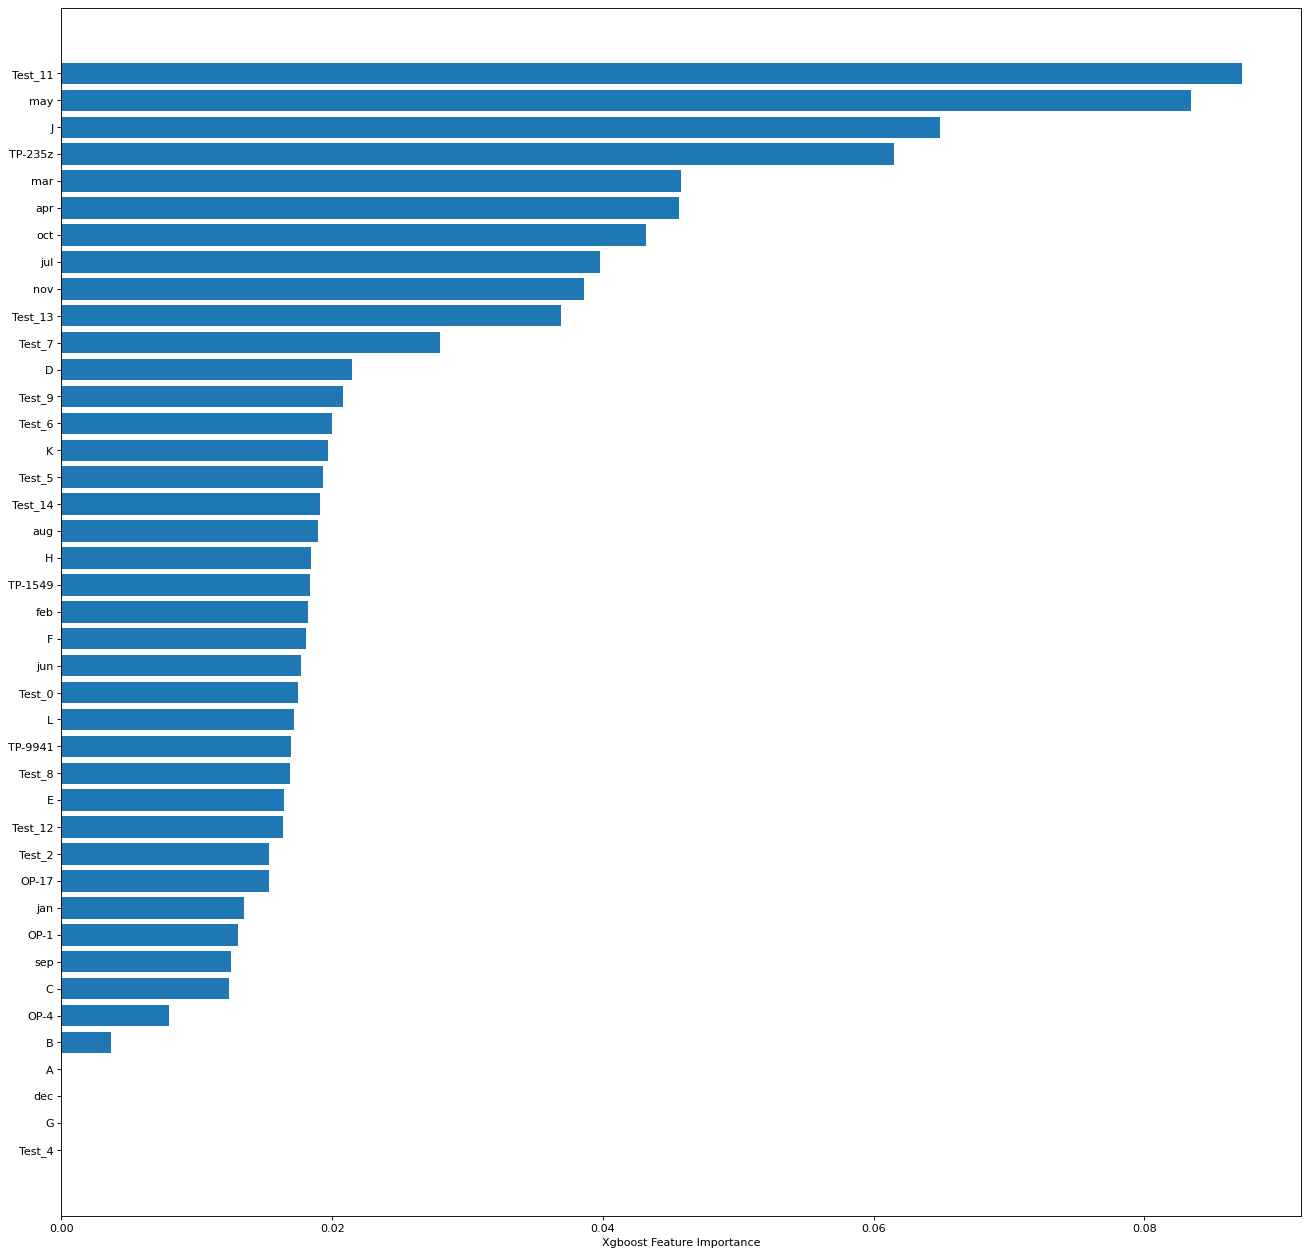

In [ ]:
plt.figure(figsize=(20, 20), dpi=80)
sorted_idx = best_.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], best_.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

# As expected, Test_11 is one of the top features, but some months seemed to have a great impact on the predictions.
# It might be useful to look further and discover how these months differed.
# Also, TP-235z seems significant in predicting positives, is this a type of machine? looking further into it might uncover type of machinery that should be avoided

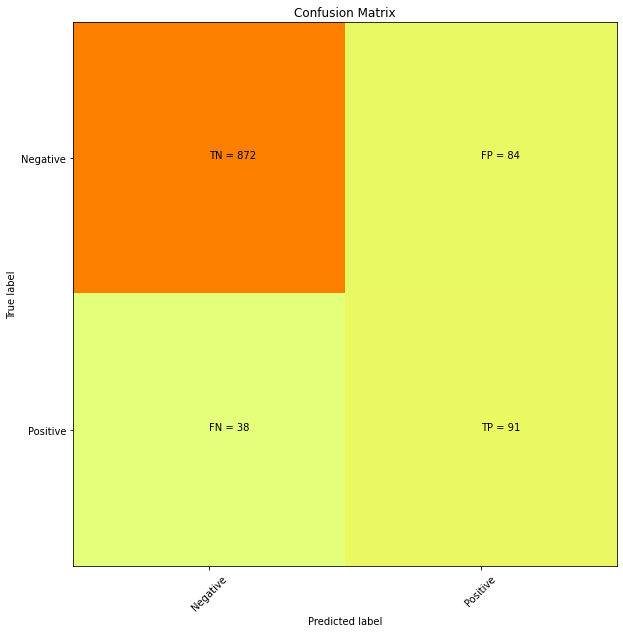

In [ ]:
def confusio_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

confusio_matrix(y_val,pred_val)

# As expected, there's a high number of true negatives since most RMA's are negative, the problem are the false negatives as the cost of such error is very high according to the problem description, I will discuss an idea on the next part 

# Something to think about:

- Why f1_score is the selected metric?
- Are there metrics that you think would better suit this Use-Case?
- What metrics are not appropriate for such a Use-Case?

##Your answers here

f1 is a nice approach, it balances precision and recall which focus on the positives predicted.
This works great since according to the problem's description - the cost of error when failing to predict a positive is great, far greater than any other type of error.
Also, the positives in the data are rare compared to the negatives, missing the importance of the positives can be a common mistake when a model's metric is its accuracy or specificity, in such case the model will simply predict negatives and cost us greatly in predicting those positives.
Another metric that could work is the auc since it measures separability and wont cause a bias of predictions towards the majority for accuracy.

Rather than a classification problem, this problem could be better described as a regression problem.
By finding out what is the probability for a positive prediction, its possible to optimize and classify according to such probability (p) that will cause more false positives but in such way that it would still be worth the cost, in favor of lowering the false negatives which are critical.
Another alternatives is also increasing the weight on positives that will impact the overall model.

In [ ]:
split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for train_index, val_index in split.split(df_rma_train, df_rma_train['RMA']):
    x_train=df_rma_train.loc[train_index]
    x_val=df_rma_train.loc[val_index]

y_train = x_train.RMA
y_val = x_val.RMA
x_train = x_train.drop(['RMA'], axis=1)
x_val = x_val.drop(['RMA'], axis=1)



params= {'n_estimators':randint(low=250, high=450), 'max_features':randint(low=1, high=41), 'scale_pos_weight': [20], 'learning_rate': uniform(0.01, 0.1)} 


xg_class= xgb.XGBClassifier(random_state=1, use_label_encoder=False)
rnd_search=RandomizedSearchCV(xg_class, param_distributions=params, n_iter=50, cv=2,  scoring='recall', random_state=1)
rnd_search.fit(x_train, y_train)
best_ = rnd_search.best_estimator_
pred_train = best_.predict(x_train)
pred_val = best_.predict(x_val)

print('f1', f1_score(pred_val, y_val))
print('roc', roc_auc_score(pred_val, y_val))
print(rnd_search.best_params_)


f1 0.41144901610017887
roc 0.6230339073317949
{'learning_rate': 0.017336417174259957, 'max_features': 23, 'n_estimators': 259, 'scale_pos_weight': 20}


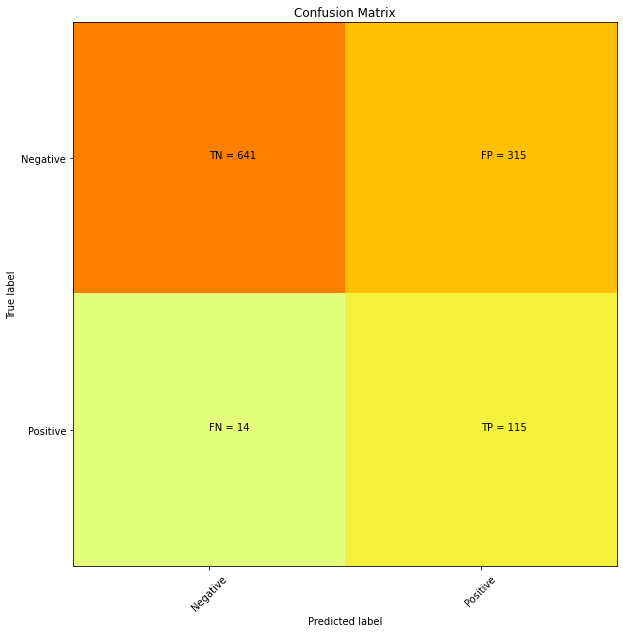

In [ ]:
confusio_matrix(y_val,pred_val)

# Predict on the test-set and export the model

In [ ]:
my_prediction = my_model.predict(df_rma_test)
my_prediction = pd.DataFrame(my_prediction)
my_prediction[0] = my_prediction[0].replace(0.0, 'False')
my_prediction[0] = my_prediction[0].replace(1.0, 'True')
my_prediction.to_csv('my_prediction.csv', index = False)
with open('my_model.pkl', 'wb') as f:
    pickle.dump(my_model, f)

**Well done!!**

Congratulations!!! You are almost done. Please,pack your notebook, model and prediction file in one zip file and send us back through the e-mail which you received the assignment from.